# Goal: build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. 

In [2]:
# ignore warnings
import  warnings
warnings.simplefilter('ignore')

# import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

# use h2o data frame: for large dataset, H2O is really fast. 
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [5]:
# import data
data = pd.read_csv('/Users/cherry/Desktop/Fraud/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
# import another dataset: mapping each numeric ip address to its country
ad2c = pd.read_csv('/Users/cherry/Desktop/Fraud/IpAddress_to_Country.csv')
ad2c.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
# add country as a feature in fraud data
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ad2c[(ad2c['lower_bound_ip_address'] <= ip_address) &
                          (ad2c['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [8]:
# feature engineering - possible frauds
# 1. small time difference between signup time and purchase time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff


In [9]:
# 2. different user ids for the same device 
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [10]:
# 3. different user ids from the same IP address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [11]:
# 4. signup/ purchase day of a week and week of a year
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [12]:
# have a look at our new data after features engineering
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [13]:
# delete unnecessary features such as user id and device_id and keep other features
features = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[features]
data.head()


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [16]:
# build the model
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_202-ea"; Java(TM) SE Runtime Environment (build 1.8.0_202-ea-b03); Java HotSpot(TM) 64-Bit Server VM (build 25.202-b03, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/vq/21sx2tnx3nqc04rh67lg5jxh0000gn/T/tmp5ksqcl82
  JVM stdout: /var/folders/vq/21sx2tnx3nqc04rh67lg5jxh0000gn/T/tmp5ksqcl82/h2o_cherry_started_from_python.out
  JVM stderr: /var/folders/vq/21sx2tnx3nqc04rh67lg5jxh0000gn/T/tmp5ksqcl82/h2o_cherry_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_cherry_a6qds8
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [17]:
# convert to h2o frame
h2o_df = H2OFrame(data)

# convert features to categories
for f in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[f] = h2o_df[f].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.501740430938508,,24.658571126052173,36.93537243898567,,,,33.14070358409671,,40942.584427444956,1.6843665625496433,1.6027185134205137,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798854,,11.651556782719474,18.32276214866212,,,,8.617733490961495,,26049.661902118358,2.6169536028041693,2.596239527375835,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


In [18]:
# Split training and test sets (70/30)
# binary feature - class: use stratified split method to aviod imbalance
data_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[data_split == 'train']
test = h2o_df[data_split == 'test']

# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-01-27 00:31:58,0.091 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-01-27 00:31:59,1.420 sec,1.0,0.330323,0.761666,0.954907,0.240108,1.932086,0.106435,0.255427,1.633138,0.782921,0.098951,7.433134,0.063706
2,,2019-01-27 00:32:00,2.146 sec,2.0,0.333707,0.662977,0.959580,0.270685,1.945869,0.100341,0.212081,0.672350,0.804631,0.133855,10.168294,0.045684
3,,2019-01-27 00:32:01,2.816 sec,3.0,0.337360,0.577955,0.962921,0.300483,1.959744,0.096653,0.205984,0.441324,0.818400,0.148885,10.585434,0.044250
4,,2019-01-27 00:32:01,3.276 sec,4.0,0.338654,0.532992,0.965244,0.314901,1.967643,0.092693,0.204538,0.348968,0.824290,0.155863,10.646046,0.044184
5,,2019-01-27 00:32:02,4.011 sec,5.0,0.340130,0.490398,0.967536,0.328751,1.975654,0.091093,0.203784,0.302226,0.827033,0.162059,10.655368,0.044339
6,,2019-01-27 00:32:02,4.507 sec,6.0,0.336884,0.451830,0.972704,0.342774,1.980406,0.082898,0.203543,0.280094,0.830336,0.164311,10.679152,0.044118
7,,2019-01-27 00:32:03,5.070 sec,7.0,0.336006,0.420208,0.976209,0.356146,1.985450,0.080232,0.203377,0.259090,0.832612,0.165705,10.679152,0.044449
8,,2019-01-27 00:32:03,5.702 sec,8.0,0.334299,0.396043,0.979517,0.366178,1.988771,0.074378,0.203280,0.248835,0.833232,0.167823,10.679152,0.044405
9,,2019-01-27 00:32:04,6.348 sec,9.0,0.335495,0.381204,0.981866,0.378333,1.991627,0.069957,0.203173,0.232175,0.834445,0.169733,10.679152,0.044184


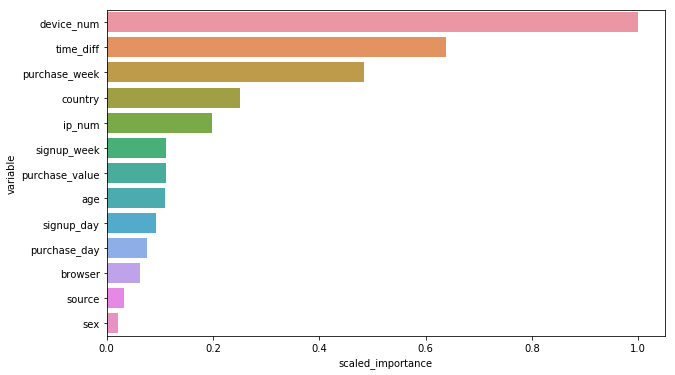

In [22]:
# Plot feature importance
# varimp: Calculation Of Variable Importance For Regression And Classification Models, for objects produced by train
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='scaled_importance', y='variable', data = importance)
plt.show()

In [32]:
# Make predictions 
train_data = train.as_data_frame()['class'].values
test_data = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

print(test_data)
print(test_pred > 0.5)


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
[0 0 0 ... 0 0 0]
[False False False ... False False False]


In [35]:
# get model scores
train_fpr, train_tpr, _ = roc_curve(train_data, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_data, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

print(test_fpr)
print(test_tpr)

# Classification report
print(classification_report(y_true=test_data, y_pred=(test_pred > 0.5).astype(int)))
# test_pred > 0.5: threshold is 0.5

[0.         0.         0.         ... 0.99072722 0.9907759  1.        ]
[0.         0.51849234 0.51943463 ... 0.99717314 0.99717314 1.        ]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

   micro avg       0.96      0.96      0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



In [36]:
# add (0,0) to plot AUC
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

print(test_fpr)
print(test_tpr)



[0.         0.         0.         ... 0.99072722 0.9907759  1.        ]
[0.         0.         0.51849234 ... 0.99717314 0.99717314 1.        ]


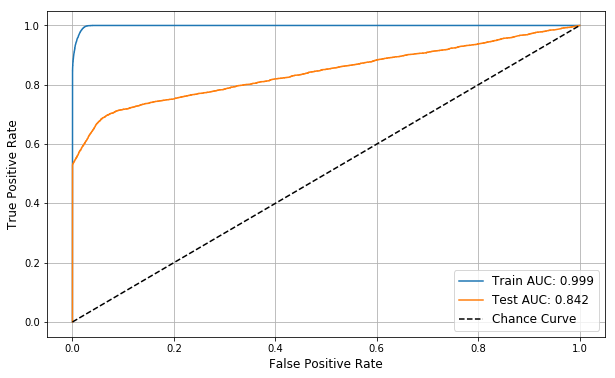

In [38]:
# plot AUC
# when there are imbalanced classes, it's more useful to report AUC for a precision-recall curve.
# AUC meatures accuracy. 1 represents a perfect test; 0.5 represents a worthless test (change curve)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_tpr, train_tpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# how different assumptions about the cost of false positives vs true positives would impact the model.
# 1. if we want to minimize FPR: TPR = ~0.5 and FPR = zero 
# 2. if we want to maximize TPR, we will have to decrease the cut-off. 
# lower the threshold, classify more events as “1”: true positive goes up, false positive will also go up.

In [39]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_9dcc closed.


In [ ]:
# explanation of the model:
# different users in the same device are more likely to be classified as at risk; 
# small time difference between signup time and purshase time
# puchase weeks aer in the first five weeks of a year
# users in certain counties.

In [ ]:
# how to use the moel:
# If predicted fraud probability < X, no fraudulent activities. (majority)
# If X <= predicted fraud probability < Z, the user in the risk of frauds;
# solution: use additional verification step, including verifing phone number via a code sent by SMS or email.
# If predicted fraud probability >= Z, there is a high risk of a fraud.
# solution: warn the user; freeze the account; check the activity manually.